In [1]:
%autosave 0
import os
import glob
import numpy 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np 
import tensorflow as tf
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import scatter_matrix 
from numpy import set_printoptions
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.compose import ColumnTransformer
from datetime import datetime
from mlflow import log_metric, log_param

set_printoptions(precision=0)
pd.set_option("display.precision", 2)
pd.option_context('display.float_format', '{:0f}'.format);

seed = 15
tf.random.set_seed(seed)
# tf.set_random_seed(seed)
numpy.random.seed(seed)

Autosave disabled


## création du dataset final

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('../csv/dataset_final_*.{}'.format(extension))]

In [3]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "../csv/dataset_final.csv", index=False, encoding='utf-8-sig')

## préprocessing du dataset

In [4]:
# Importation du fichier csv dans un dataframe
df_train_full = read_csv('../csv/dataset_final.csv', index_col=0)

In [5]:
df_train_full = df_train_full.set_index('ref')
df_train_full = df_train_full.drop(columns=['titre'])
print(df_train_full.shape)
df_train_full.head(5)

(8889, 12)


,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage,output
ref,,,,,,,,,,,,
/fr/properties/20949a-s2519.htm,Thiviers,Dordogne,Aquitaine,manoir,385.0,3446.0,12.0,7.0,False,True,False,475000
/fr/properties/66377a-4508aail.htm,Casteljaloux,Lot-et-Garonne,Aquitaine,terrain,8610.0,8610.0,NaN,NaN,False,False,False,74000
/fr/properties/58577a-609.htm,Périgueux,Dordogne,Aquitaine,fond de commerce,200.0,NaN,5.0,NaN,False,True,True,386900
/fr/properties/20949a-s2519.htm,Thiviers,Dordogne,Aquitaine,manoir,385.0,3446.0,12.0,7.0,False,True,False,475000
/fr/properties/66377a-4508aail.htm,Casteljaloux,Lot-et-Garonne,Aquitaine,terrain,8610.0,8610.0,NaN,NaN,False,False,False,74000


In [6]:
df_train_full.describe()

,living_area_m2,lot_size_m2,nb_room,nb_bedroom,output
count,8247.00,6.84e+03,7256.00,7137.00,8.89e+03
mean,324.08,1.69e+04,6.80,4.30,4.11e+05
std,1097.77,7.30e+04,3.73,2.24,6.15e+05
min,1.00,1.00e+00,2.00,2.00,8.00e+03
25%,112.00,9.91e+02,4.00,3.00,1.56e+05
50%,169.00,2.50e+03,6.00,4.00,2.68e+05
75%,260.00,7.00e+03,8.00,5.00,4.57e+05
max,32767.00,1.94e+06,50.00,42.00,1.60e+07


In [7]:
Y_trainfull = df_train_full['output']
X_trainfull = df_train_full.drop('output', axis=1)

In [8]:
print(Y_trainfull.shape)
print(X_trainfull.shape)

(8889,)
(8889, 11)


# Traitement des variables catégorielles

In [9]:
cat_columns = ['city', 'departement', 'region', 'type']

In [10]:
city_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['city'].unique()]))
])

In [11]:
departement_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['departement'].unique()]))
])

In [12]:
region_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['region'].unique()]))
])

In [13]:
type_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['type'].unique()]))
])

# Traitement des valeurs manquantes

In [14]:
df_train_full.isna().any()

city              False
departement       False
region            False
type              False
living_area_m2     True
lot_size_m2        True
nb_room            True
nb_bedroom         True
pool              False
cellar            False
garage            False
output            False
dtype: bool

In [15]:
boolean_columns = ['pool', 'cellar', 'garage']
area_column = ['living_area_m2']
ground_column = ['lot_size_m2']
nb_room_column = ['nb_room']
nb_bedroom_column = ['nb_bedroom']

boolean_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('imputer1', SimpleImputer(missing_values=True, strategy='constant', fill_value=1)),
])

In [16]:
area_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [17]:
ground_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

In [18]:
room_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1))
])

In [19]:
bedroom_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1))
])

# Construction du pipeline de pré-traitement

In [20]:
preprocess_pipe = ColumnTransformer(transformers=[
    ('city', city_pipe, ['city']),
    ('departement', departement_pipe, ['departement']),
    ('region', region_pipe, ['region']),
    ('type', type_pipe, ['type']),
#     ('bool', boolean_pipe, boolean_columns),
    ('area', area_pipe, area_column),
    ('ground', ground_pipe, ground_column),
    ('room', room_pipe, nb_room_column),
    ('bedroom', bedroom_pipe, nb_bedroom_column),
])

# Choix du modèle et intégration dans la pipeline

In [21]:
def mae_model(preprocess_pipe, model):

    full_pipe = Pipeline(steps=[
        ('pp', preprocess_pipe),
        ('model', model)
    ])

    X_train, X_val, Y_train, Y_val = train_test_split(X_trainfull, Y_trainfull, random_state = seed)

    full_pipe.fit(X_train, Y_train);

    y_train_pred = full_pipe.predict(X_train)
    y_val_pred = full_pipe.predict(X_val)

    mae_train = round(metrics.mean_absolute_error(Y_train, y_train_pred), 0)
    mae_val = round(metrics.mean_absolute_error(Y_val, y_val_pred), 0)

    return mae_train, mae_val

In [22]:
lin = LinearRegression()
log = LogisticRegression()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
bag = BaggingRegressor()
xgb = XGBRegressor()
xgb_rf = XGBRFRegressor()

In [23]:
models = [lin, log, tree, rf, bag, xgb, xgb_rf]

In [24]:
errors = []
for model in models:
    errors += [mae_model(preprocess_pipe, model)]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


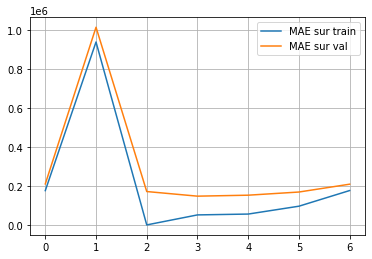

In [25]:
plt.plot(errors);
plt.grid();
plt.legend(['MAE sur train', 'MAE sur val']);

Du graphique précédent, nous choisissons de conserver le modèle 5 à savoir le modèle xgbregressor

# Génération du modèle retenu

In [26]:
model = XGBRegressor()

In [27]:
full_pipe = Pipeline(steps=[
        ('pp', preprocess_pipe),
        ('model', model)
    ])

In [28]:
full_pipe.fit(X_trainfull, Y_trainfull);

## exportation du modèle

In [29]:
# suppression du fichier si un ancien modèle existe
if os.path.exists('../models/full_pipe.file'):
    os.remove('../models/full_pipe.file')
else:
    print("Impossible de supprimer le fichier car il n'existe pas")

Impossible de supprimer le fichier car il n'existe pas


In [30]:
model_file_name = "../models/full_pipe_" + str(datetime.today())+ ".file"
last_model_name = "../models/full_pipe.file"

In [31]:
pickle.dump(full_pipe, open(model_file_name, "wb" ))
pickle.dump(full_pipe, open(last_model_name, "wb" ))

# Prédictions

## chargement du modèle

In [32]:
full_pipe = pickle.load(open(last_model_name, "rb"))

In [33]:
type(full_pipe)

sklearn.pipeline.Pipeline

## prédiction sur trainfull complet

In [34]:
X_trainfull

,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage
ref,,,,,,,,,,,
/fr/properties/20949a-s2519.htm,Thiviers,Dordogne,Aquitaine,manoir,385.0,3446.0,12.0,7.0,False,True,False
/fr/properties/66377a-4508aail.htm,Casteljaloux,Lot-et-Garonne,Aquitaine,terrain,8610.0,8610.0,NaN,NaN,False,False,False
/fr/properties/58577a-609.htm,Périgueux,Dordogne,Aquitaine,fond de commerce,200.0,NaN,5.0,NaN,False,True,True
/fr/properties/20949a-s2519.htm,Thiviers,Dordogne,Aquitaine,manoir,385.0,3446.0,12.0,7.0,False,True,False
/fr/properties/66377a-4508aail.htm,Casteljaloux,Lot-et-Garonne,Aquitaine,terrain,8610.0,8610.0,NaN,NaN,False,False,False
/fr/properties/58577a-609.htm,Périgueux,Dordogne,Aquitaine,fond de commerce,200.0,NaN,5.0,NaN,False,True,True
/fr/properties/20949a-s2519.htm,Thiviers,Dordogne,Aquitaine,manoir,385.0,3446.0,12.0,7.0,False,True,False
/fr/properties/66377a-4508aail.htm,Casteljaloux,Lot-et-Garonne,Aquitaine,terrain,8610.0,8610.0,NaN,NaN,False,False,False
/fr/properties/58577a-609.htm,Périgueux,Dordogne,Aquitaine,fond de commerce,200.0,NaN,5.0,NaN,False,True,True


In [35]:
y_train_pred = full_pipe.predict(X_trainfull)

In [36]:
mae_train = round(metrics.mean_absolute_error(Y_trainfull, y_train_pred), 0)
print('MAE sur train : ', mae_train, '€')

MAE sur train :  104203.0 €


In [37]:
trainfull_pred = pd.DataFrame(y_train_pred)
trainfull_pred.to_csv('../csv/trainfull_pred.csv', index=False)
Y_trainfull.to_csv('../csv/Y_trainfull.csv', index=False)

## prédiction sur valeur unique

In [38]:
new_value = pd.DataFrame(data = [
    ['Bordeaux', 'Gironde', 'Aquitaine', 'appartement', 54, 12, 1, 1, 'True', 'True', 'True']
    ], index = ['test'], columns = X_trainfull.columns)

new_value.index.name = 'ref'
new_value

,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage
ref,,,,,,,,,,,
test,Bordeaux,Gironde,Aquitaine,appartement,54,12,1,1,True,True,True


In [39]:
full_pipe.predict(new_value)

array([304685.], dtype=float32)

# Enregistrement des résultats si voulus (mettre log = True)
-> accessible sous localhost:3000

In [40]:
log_param("X_trainfull.shape", X_trainfull.shape)
log_metric("MAE sur train", mae_train)

/opt/conda/lib/python3.7/site-packages/py4j/java_collections.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (
